In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

<h2>Textbook example: Ramsey-Cass-Koopmans model of optimal savings</h2>

After a bit of algebra, the Ramsey-Cass-Koopmans model with Cobb-Douglas production and CRRA preferences can be reduced down to the following system of ODEs and boundary conditions...

\begin{align}
    \dot{k}(t) =& k(t)^{\alpha} - c - (g + n + \delta) k(t),\ k(0) = k_0 \\
    \dot{c}(t) =& \Bigg[\frac{\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g}{\theta}\Bigg]c,\ \lim_{t\rightarrow \infty} c(t) = c^*
\end{align}

...the above equations say that...

1. the rate of change of the stock of physical capital (per unit effective labor supply) is the difference between the actual level of investment in physical capital and the amount of investment required to maintain the current level of physical capital;
2. the rate of change in consumption (per unit effective labor supply) is proportional to the difference between the rate of return on capital (less depreciation) and the effective discount rate, and inversely proportional to the level of relative risk aversion.

In [3]:
def cobb_douglas_output(k, alpha, **params):
    return k**alpha

def cobb_douglas_mpk(k, alpha, **params):
    return alpha * k**(alpha - 1)

def standard_ramsey_model(t, k, c, alpha, delta, g, n, rho, theta, **params):
    out = [cobb_douglas_output(k, alpha) - c - (g + n + delta) * k,
           ((cobb_douglas_mpk(k, alpha) - delta - rho - theta * g) / theta) * c]
    return out

def initial_condition(t, k, c, k0, **params):
    return [k - k0]

def terminal_condition(t, k, c, **params):
    return [c - equilibrium_consumption(**params)]

def equilibrium_capital(alpha, delta, g, n, rho, theta, **params):
    return (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))
    
def equilibrium_consumption(alpha, delta, g, n, rho, theta, **params):
    kss = equilibrium_capital(alpha, delta, g, n, rho, theta)
    return kss**alpha - (g + n + delta) * kss

To complete the model we need to define some parameter values.

In [4]:
params = {'g': 0.02, 'n': 0.02, 'alpha': 0.15, 'delta': 0.04, 'k0': 1.0,
          'theta': 1.0, 'rho': 0.02}

<h2>Solving the model with pyCollocation</h2>

<h3>Defining a `pycollocation.TwoPointBVP` instance</h3>

In [5]:
pycollocation.problems.TwoPointBVP?

In [6]:
standard_ramsey_bvp = pycollocation.problems.TwoPointBVP(bcs_lower=initial_condition,
                                                         bcs_upper=terminal_condition,
                                                         number_bcs_lower=1,
                                                         number_odes=2,
                                                         params=params,
                                                         rhs=standard_ramsey_model,
                                                         )

### Finding a good initial guess for $k(t)$

Theory tells us that, starting from some initial condition $k_0$, the solution to the Solow model converges monotonically toward its long run equilibrium value $k^*$. Our initial guess for the solution should preserve this property...

In [7]:
def create_mesh(basis_kwargs, num, problem):
    # compute equilibrium values
    cstar = equilibrium_consumption(**problem.params)
    kstar = equilibrium_capital(**problem.params)
    ystar = cobb_douglas_output(kstar, **problem.params)

    # create the mesh for capital
    ts = np.linspace(*basis_kwargs['domain'], num=num)
    ks = kstar - (kstar - problem.params['k0']) * np.exp(-ts)

    # create the mesh for consumption
    s = 1 - (cstar / ystar)
    ys = cobb_douglas_output(ks, **problem.params)
    cs = (1 - s) * ys

    return ts, ks, cs

def fit_initial_polys(basis_kwargs, num, problem):
    ts, ks, cs = create_mesh(basis_kwargs, num, problem)
    basis_poly = getattr(np.polynomial, basis_kwargs['kind'])
    capital_poly = basis_poly.fit(ts, ks, basis_kwargs['degree'],
                                  basis_kwargs['domain'])
    consumption_poly = basis_poly.fit(ts, cs, basis_kwargs['degree'],
                                      basis_kwargs['domain'])
    return capital_poly, consumption_poly


### Solving the model

In [8]:
pycollocation.solvers.Solver?

In [9]:
basis_kwargs = {'kind': 'Chebyshev', 'domain': [0, 100], 'degree': 15}
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
polynomial_roots = polynomial_basis.nodes(**basis_kwargs)
initial_polys = fit_initial_polys(basis_kwargs, 1000, standard_ramsey_bvp)
capital_poly, consumption_poly = initial_polys
initial_coefs = np.hstack([poly.coef for poly in initial_polys])

In [10]:
solver = pycollocation.solvers.Solver(polynomial_basis)
solution = solver.solve(basis_kwargs, initial_coefs,
                        polynomial_roots, standard_ramsey_bvp)


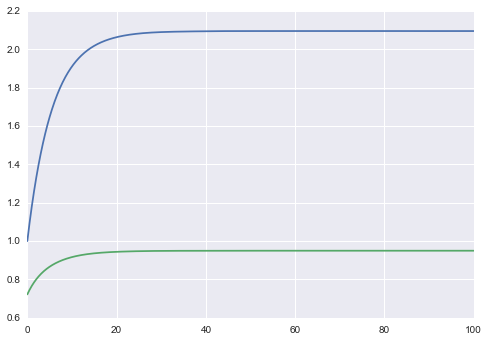

In [11]:
ts, _, _ = create_mesh(basis_kwargs, 1000, standard_ramsey_bvp)
k_soln, c_soln = solution.evaluate_solution(ts)
plt.plot(ts, k_soln)
plt.plot(ts, c_soln)
plt.show()

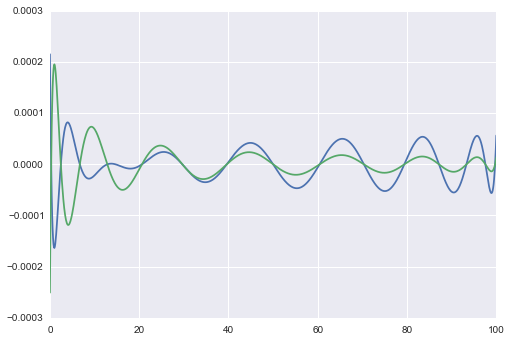

In [12]:
k_resids, c_resids = solution.evaluate_residual(ts)
plt.plot(ts, k_resids)
plt.plot(ts, c_resids)

plt.show()

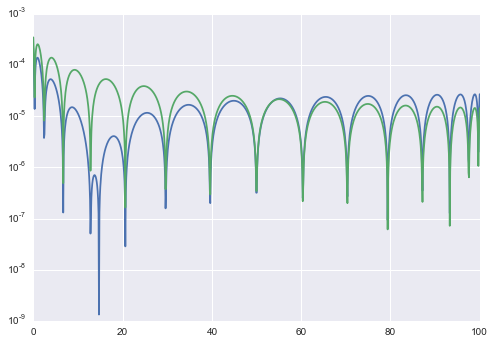

In [13]:
k_normalized_resids, c_normalized_resids = solution.normalize_residuals(ts)
plt.plot(ts, np.abs(k_normalized_resids))
plt.plot(ts, np.abs(c_normalized_resids))
plt.yscale('log')
plt.show()

<h1> Generic Ramsey-Cass-Koopmans model</h1>

Can we refactor the above code so that we can solve a Ramsey-Cass-Koopmans model for arbitrary $f$ and $u$? Yes!

In [93]:
import functools

import numpy as np


class RamseyCassKoopmansModel(pycollocation.problems.TwoPointBVP):
    """
    Class representing a generic Solow growth model.

    Attributes
    ----------
    equilibrium_capital : function
        Equilibrium value for capital (per unit effective labor).
    equilibrium_consumption : function
        Equilibrium value for consumption (per unit effective labor).
    intensive_output : function
        Output (per unit effective labor supply).
    marginal_product_capital : function
        Marginal product of capital (i.e., first derivative of intensive output).
    params : dict(str: float)
        Dictionary of model parameters.
    pratt_arrow_risk_aversion : function
        Pratt-Arrow relative risk aversion function.

    """

    def __init__(self, A, f, k_star, mpk, params):
        """
        Initialize an instance of the RamseyCassKoopmans class.

        Parameters
        ----------
        A : function
            Pratt-Arrow absolute risk aversion function.
        f : function
            Output (per unit effective labor supply).
        k_star : function
            Equilibrium (i.e., steady-state) value for capital stock (per unit
            effective labor supply).
        mpk : function
            Marginal product of capital (per unit effective labor supply).
        params : dict(str: float)
            Dictionary of model parameters

        """
        self._equilibrium_capital = k_star
        self._intensive_output = f
        self._marginal_product_capital = mpk
        self._pratt_arrow_risk_aversion = A
        
        # construct the terminal condition
        c_star = self._c_star_factory(k_star)
        terminal_condition = self._terminal_condition_factory(c_star)
        self._equilibrium_consumption = c_star
        
        # construct the RHS of the system of ODEs
        rhs = self._rhs_factory(A, f, mpk)
        
        super(RamseyCassKoopmansModel, self).__init__(self._initial_condition,
                                                      terminal_condition, 1, 2,
                                                      params, rhs)
    @property
    def equilibrium_capital(self):
        return self._equilibrium_capital
    
    @property
    def equilibrium_consumption(self):
        return self._equilibrium_consumption
    
    @property
    def intensive_output(self):
        return self._intensive_output
    
    @property
    def marginal_product_capital(self):
        return self._marginal_product_capital
    
    @property
    def pratt_arrow_risk_aversion(self):
        return self._pratt_arrow_risk_aversion
    
    @staticmethod
    def _actual_investment(k, c, f, **params):
        return f(k, **params) - c
    
    @staticmethod
    def _breakeven_investment(k, delta, g, n, **params):
        return (g + n + delta) * k

    @staticmethod
    def _c_dot(t, k, c, A, mpk, delta, g, rho, **params):
        return (((mpk(k, **params) - delta - rho) / A(t, c, **params)) - g) * c
    
    @staticmethod
    def _initial_condition(t, k, c, k0, **params):
        return [k - k0]

    @classmethod
    def _k_dot(cls, t, k, c, f, delta, g, n, **params):
        k_dot = (cls._actual_investment(k, c, f, **params) -
                 cls._breakeven_investment(k, delta, g, n))
        return k_dot

    @classmethod
    def _ramsey_model(cls, t, k, c, A, f, mpk, delta, g, n, rho, **params):
        out = [cls._k_dot(t, k, c, f, delta, g, n, **params),
               cls._c_dot(t, k, c, A, mpk, delta, g, rho, **params)]
        return out
    
    @classmethod
    def _rhs_factory(cls, A, f, mpk):
        return functools.partial(cls._ramsey_model, A=A, f=f, mpk=mpk)
    
    @staticmethod
    def _terminal_condition(t, k, c, c_star, **params):
        return [c - c_star(**params)]

    @classmethod
    def _terminal_condition_factory(cls, c_star):
        return functools.partial(cls._terminal_condition, c_star=c_star)
    
    def _c_star(self, k_star, **params):
        k = k_star(**params)
        c_star = (self.intensive_output(k, **params) -
                  self._breakeven_investment(k, **params))
        return c_star
    
    def _c_star_factory(self, k_star):
        return functools.partial(self._c_star, k_star=k_star)



class InitialPoly(object):

    @staticmethod
    def create_mesh(basis_kwargs, num, problem):
        # compute equilibrium values
        cstar = problem.equilibrium_consumption(**problem.params)
        kstar = problem.equilibrium_capital(**problem.params)
        ystar = problem.intensive_output(kstar, **problem.params)

        # create the mesh for capital
        ts = np.linspace(*basis_kwargs['domain'], num=num)
        ks = kstar - (kstar - problem.params['k0']) * np.exp(-ts)

        # create the mesh for consumption
        s = 1 - (cstar / ystar)
        y0 = problem.intensive_output(problem.params['k0'], **problem.params)
        c0 = (1 - s) * y0
        cs = cstar - (cstar - c0) * np.exp(-ts)

        return ts, ks, cs
    
    @classmethod
    def fit_initial_polys(cls, basis_kwargs, num, problem):
        ts, ks, cs = cls.create_mesh(basis_kwargs, num, problem)
        basis_poly = getattr(np.polynomial, basis_kwargs['kind'])
        capital_poly = basis_poly.fit(ts, ks, basis_kwargs['degree'],
                                      basis_kwargs['domain'])
        consumption_poly = basis_poly.fit(ts, cs, basis_kwargs['degree'],
                                          basis_kwargs['domain'])
        return capital_poly, consumption_poly


Example usage...

In [98]:
def ces_output(k, alpha, sigma, **params):
    gamma = (sigma - 1) / sigma
    if gamma == 0:
        y = k**alpha
    else:
        y = (alpha * k**gamma + (1 - alpha))**(1 / gamma)
    return y


def ces_mpk(k, alpha, sigma, **params):
    y = ces_output(k, alpha, sigma)
    gamma = (sigma - 1) / sigma
    if gamma == 0:
        mpk = alpha * (y / k)
    else:
        mpk = alpha * k**(gamma - 1) * (y / (alpha * k**gamma + (1 - alpha)))
    return mpk


def crra_risk_aversion(t, c, theta, **params):
    return theta


def ces_equilibrium_capital(alpha, delta, g, n, rho, sigma, theta, **params):
    """Steady state value for capital stock (per unit effective labor)."""
    gamma = (sigma - 1) / sigma
    if gamma == 1:
        kss = (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))
    else:
        kss = ((1 / (1 - alpha)) * (((delta + rho + theta * g) / alpha)**(gamma / (1 - gamma)) - alpha))**(-1 / gamma)
    return kss


ces_params = {'g': 0.02, 'theta': 1.0, 'n': 0.02, 'alpha': 0.15, 'delta': 0.04,
              'sigma': 0.5, 'rho': 0.02, 'k0': 1.0}

In [99]:
generic_ramsey_bvp = RamseyCassKoopmansModel(crra_risk_aversion,
                                             ces_output,
                                             ces_equilibrium_capital,
                                             ces_mpk,
                                             ces_params)

In [100]:
basis_kwargs = {'kind': 'Chebyshev', 'domain': [0, 100], 'degree': 25}
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
polynomial_roots = polynomial_basis.nodes(**basis_kwargs)
initial_polys = fit_initial_polys(basis_kwargs, 1000, standard_ramsey_bvp)
capital_poly, consumption_poly = initial_polys
initial_coefs = np.hstack([poly.coef for poly in initial_polys])

In [101]:
solver = pycollocation.solvers.Solver(polynomial_basis)
solution = solver.solve(basis_kwargs, initial_coefs,
                        polynomial_roots, generic_ramsey_bvp)


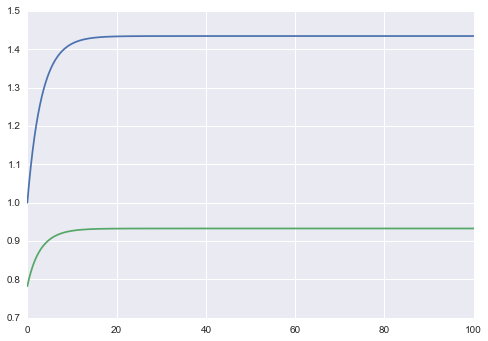

In [102]:
ts, _, _ = InitialPoly.create_mesh(basis_kwargs, 1000, generic_ramsey_bvp)
k_soln, c_soln = solution.evaluate_solution(ts)
plt.plot(ts, k_soln)
plt.plot(ts, c_soln)
plt.show()

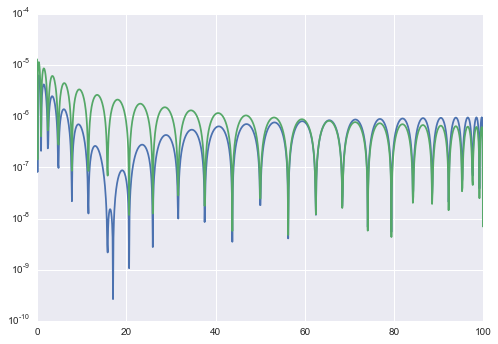

In [103]:
k_normalized_resids, c_normalized_resids = solution.normalize_residuals(ts)
plt.plot(ts, np.abs(k_normalized_resids))
plt.plot(ts, np.abs(c_normalized_resids))
plt.yscale('log')
plt.show()